<a href="https://colab.research.google.com/github/digital0923RJ/Data-Science---Kaggle-Project/blob/main/Exploring%20Mental%20Health%20Data%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/Kaggle/Exploring Mental Health Data"

Mounted at /content/drive


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.0 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import optuna
from optuna.samplers import TPESampler
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import gc
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import category_encoders as ce

In [ ]:
train = pd.read_csv(f"{DATA_PATH}/train.csv") # 학습데이터
test = pd.read_csv(f"{DATA_PATH}/test.csv") # 테스트 데이터
ori = pd.read_csv(f"{DATA_PATH}/final_depression_dataset_1.csv")

In [ ]:
def read_data(file_path):
    df = pd.read_csv(file_path)
    print(f"The shape of the dataframe is: {df.shape}")
    display(df.head(3))
    return df

df_train = read_data(f"{DATA_PATH}/train.csv")
df_test = read_data(f"{DATA_PATH}/test.csv")
df_ori = read_data(f"{DATA_PATH}/final_depression_dataset_1.csv")

The shape of the dataframe is: (140700, 20)


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1


The shape of the dataframe is: (93800, 19)


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
1,140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
2,140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No


The shape of the dataframe is: (2556, 19)


,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No


In [ ]:
df_ori["Depression"] = df_ori['Depression'].map({'Yes': 1, 'No': 0})
df_train = pd.concat(objs=[df_train, df_ori])

In [ ]:
# Drop ID,Name columns if present
if 'id' in df_train.columns and 'Name' in df_train.columns:
    df_train.drop(columns=['id','Name'], inplace=True)
if 'id' in df_test.columns and 'Name' in df_test.columns:
    df_test.drop(columns=['id','Name'], inplace=True)

In [ ]:
categorical_columns = df_train.select_dtypes(include=['object']).columns

unique_values = {col: df_train[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")

gc.collect()
# 딕셔너리 컴프리헨션을 사용함. categorical_columns에 있는 각 열에 대해 고유값의 개수를 계산한 딕셔너리임.
# {col: df_train[col].nunique()}는 열 이름과 해당 열의 고유값 개수를 키-값 쌍으로 저장함.
# unique_values.items()은 딕셔너리 키,값 쌍을 반환함
# col은 열 이름(키), unique_count 해당 열의 고유값 개수(값)임.
# 딕셔너리 각 항목을 순회하면서 열 이름과 고유값 개수를 출력하기 위해 사용됨


Gender: 2 unique values
City: 98 unique values
Working Professional or Student: 2 unique values
Profession: 64 unique values
Sleep Duration: 36 unique values
Dietary Habits: 23 unique values
Degree: 115 unique values
Have you ever had suicidal thoughts ?: 2 unique values
Family History of Mental Illness: 2 unique values


0

In [ ]:
unique_values = {
    col: {
        "unique_count": df_train[col].nunique(),
        "most_frequent": df_train[col].mode()[0] #This pandas function calculates the mode (most frequent value) of the selected column.
    }
    for col in categorical_columns
}

for col, stats in unique_values.items():
    print(f"{col}: {stats['unique_count']} unique values, Most Frequent: {stats['most_frequent']}")

Gender: 2 unique values, Most Frequent: Male
City: 98 unique values, Most Frequent: Kalyan
Working Professional or Student: 2 unique values, Most Frequent: Working Professional
Profession: 64 unique values, Most Frequent: Teacher
Sleep Duration: 36 unique values, Most Frequent: Less than 5 hours
Dietary Habits: 23 unique values, Most Frequent: Moderate
Degree: 115 unique values, Most Frequent: Class 12
Have you ever had suicidal thoughts ?: 2 unique values, Most Frequent: No
Family History of Mental Illness: 2 unique values, Most Frequent: No


In [ ]:
total_rows = len(df_train)
unique_ratios = {
    col: round(df_train[col].nunique() / total_rows * 100, 2)
    for col in categorical_columns
}

for col, ratio in unique_ratios.items():
    print(f"{col}: {ratio}% unique values")

Gender: 0.0% unique values
City: 0.07% unique values
Working Professional or Student: 0.0% unique values
Profession: 0.04% unique values
Sleep Duration: 0.03% unique values
Dietary Habits: 0.02% unique values
Degree: 0.08% unique values
Have you ever had suicidal thoughts ?: 0.0% unique values
Family History of Mental Illness: 0.0% unique values


In [ ]:
import seaborn as sns

In [ ]:
unique_details = {
    col: {
        "unique_count": df_train[col].nunique(),
        "unique_values": df_train[col].unique().tolist()
    }
    for col in categorical_columns
}

for col, stats in unique_details.items():
    print(f"{col}: {stats['unique_count']} unique values")
    print(f"Unique Values: {stats['unique_values']}")

Gender: 2 unique values
Unique Values: ['Female', 'Male']
City: 98 unique values
Unique Values: ['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur', 'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot', 'Jaipur', 'Pune', 'Lucknow', 'Meerut', 'Agra', 'Surat', 'Faridabad', 'Hyderabad', 'Srinagar', 'Ghaziabad', 'Kolkata', 'Chennai', 'Kalyan', 'Nagpur', 'Vadodara', 'Vasai-Virar', 'Delhi', 'Bhopal', 'Indore', 'Ishanabad', 'Vidhi', 'Ayush', 'Gurgaon', 'Krishna', 'Aishwarya', 'Keshav', 'Harsha', 'Nalini', 'Aditya', 'Malyansh', 'Raghavendra', 'Saanvi', 'M.Tech', 'Bhavna', 'Less Delhi', 'Nandini', 'M.Com', 'Plata', 'Atharv', 'Pratyush', 'City', '3.0', 'Less than 5 Kalyan', 'MCA', 'Mira', 'Moreadhyay', 'Morena', 'Ishkarsh', 'Kashk', 'Mihir', 'Vidya', 'Tolkata', 'Anvi', 'Krinda', 'Ayansh', 'Shrey', 'Ivaan', 'Vaanya', 'Gaurav', 'Harsh', 'Reyansh', 'Kashish', 'Kibara', 'Vaishnavi', 'Chhavi', 'Parth', 'Mahi', 'Tushar', 'MSc', 'No', 'Rashi', 'ME', 'Molkata', 'Researcher', 'Kagan', 

<ipython-input-16-23f63c282bd7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')


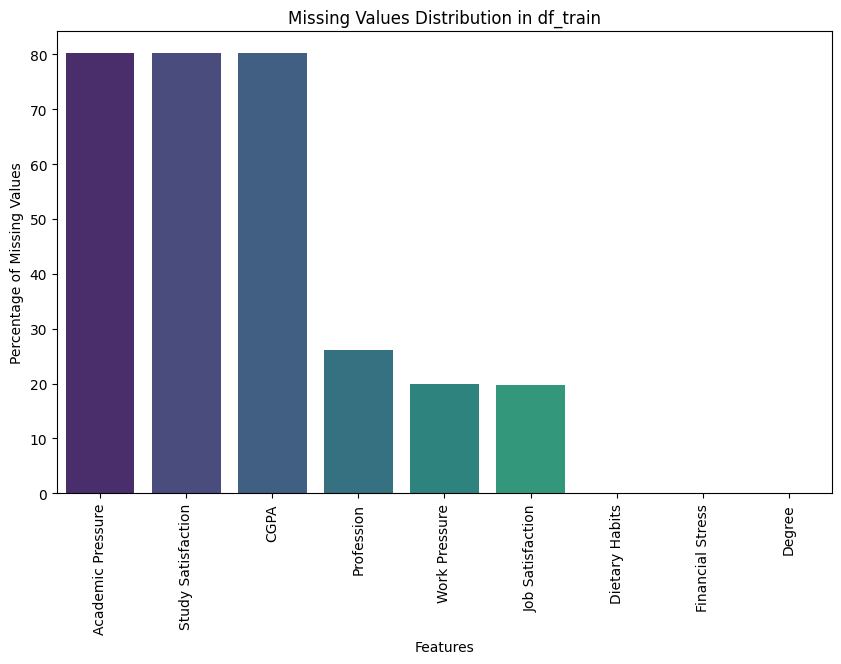

In [ ]:
missing_values = df_train.isnull().mean() * 100
missing_values = missing_values[missing_values >0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Distribution in df_train')
plt.show()

In [ ]:
!pip install dython # 범주형 데이터를 분석하는데 유용함. 데이터 간의 관계를 분석하고 상관관계를 계산하고 시각화 하는데 도움

In [ ]:
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

missing_threshold = 0.95

high_missing_columns = df_train.columns[df_train.isnull().mean() > missing_threshold]

df_train = df_train.drop(columns=high_missing_columns)
df_test = df_test.drop(columns=high_missing_columns)
target = 'Depression'

# Exclude the target variable from the loop
for column in df_train.columns:
    if column == target:  # Skip the target column
        continue
    if df_train[column].isnull().any():
        if df_train[column].dtype == 'object':
            mode_value = df_train[column].mode()[0]
            df_train[column].fillna(mode_value, inplace=True)
            df_test[column].fillna(mode_value, inplace=True)
        else:
            median_value = df_train[column].median()
            df_train[column].fillna(median_value, inplace=True)
            df_test[column].fillna(median_value, inplace=True)

<ipython-input-17-84ca647598ae>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[column].fillna(mode_value, inplace=True)
<ipython-input-17-84ca647598ae>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

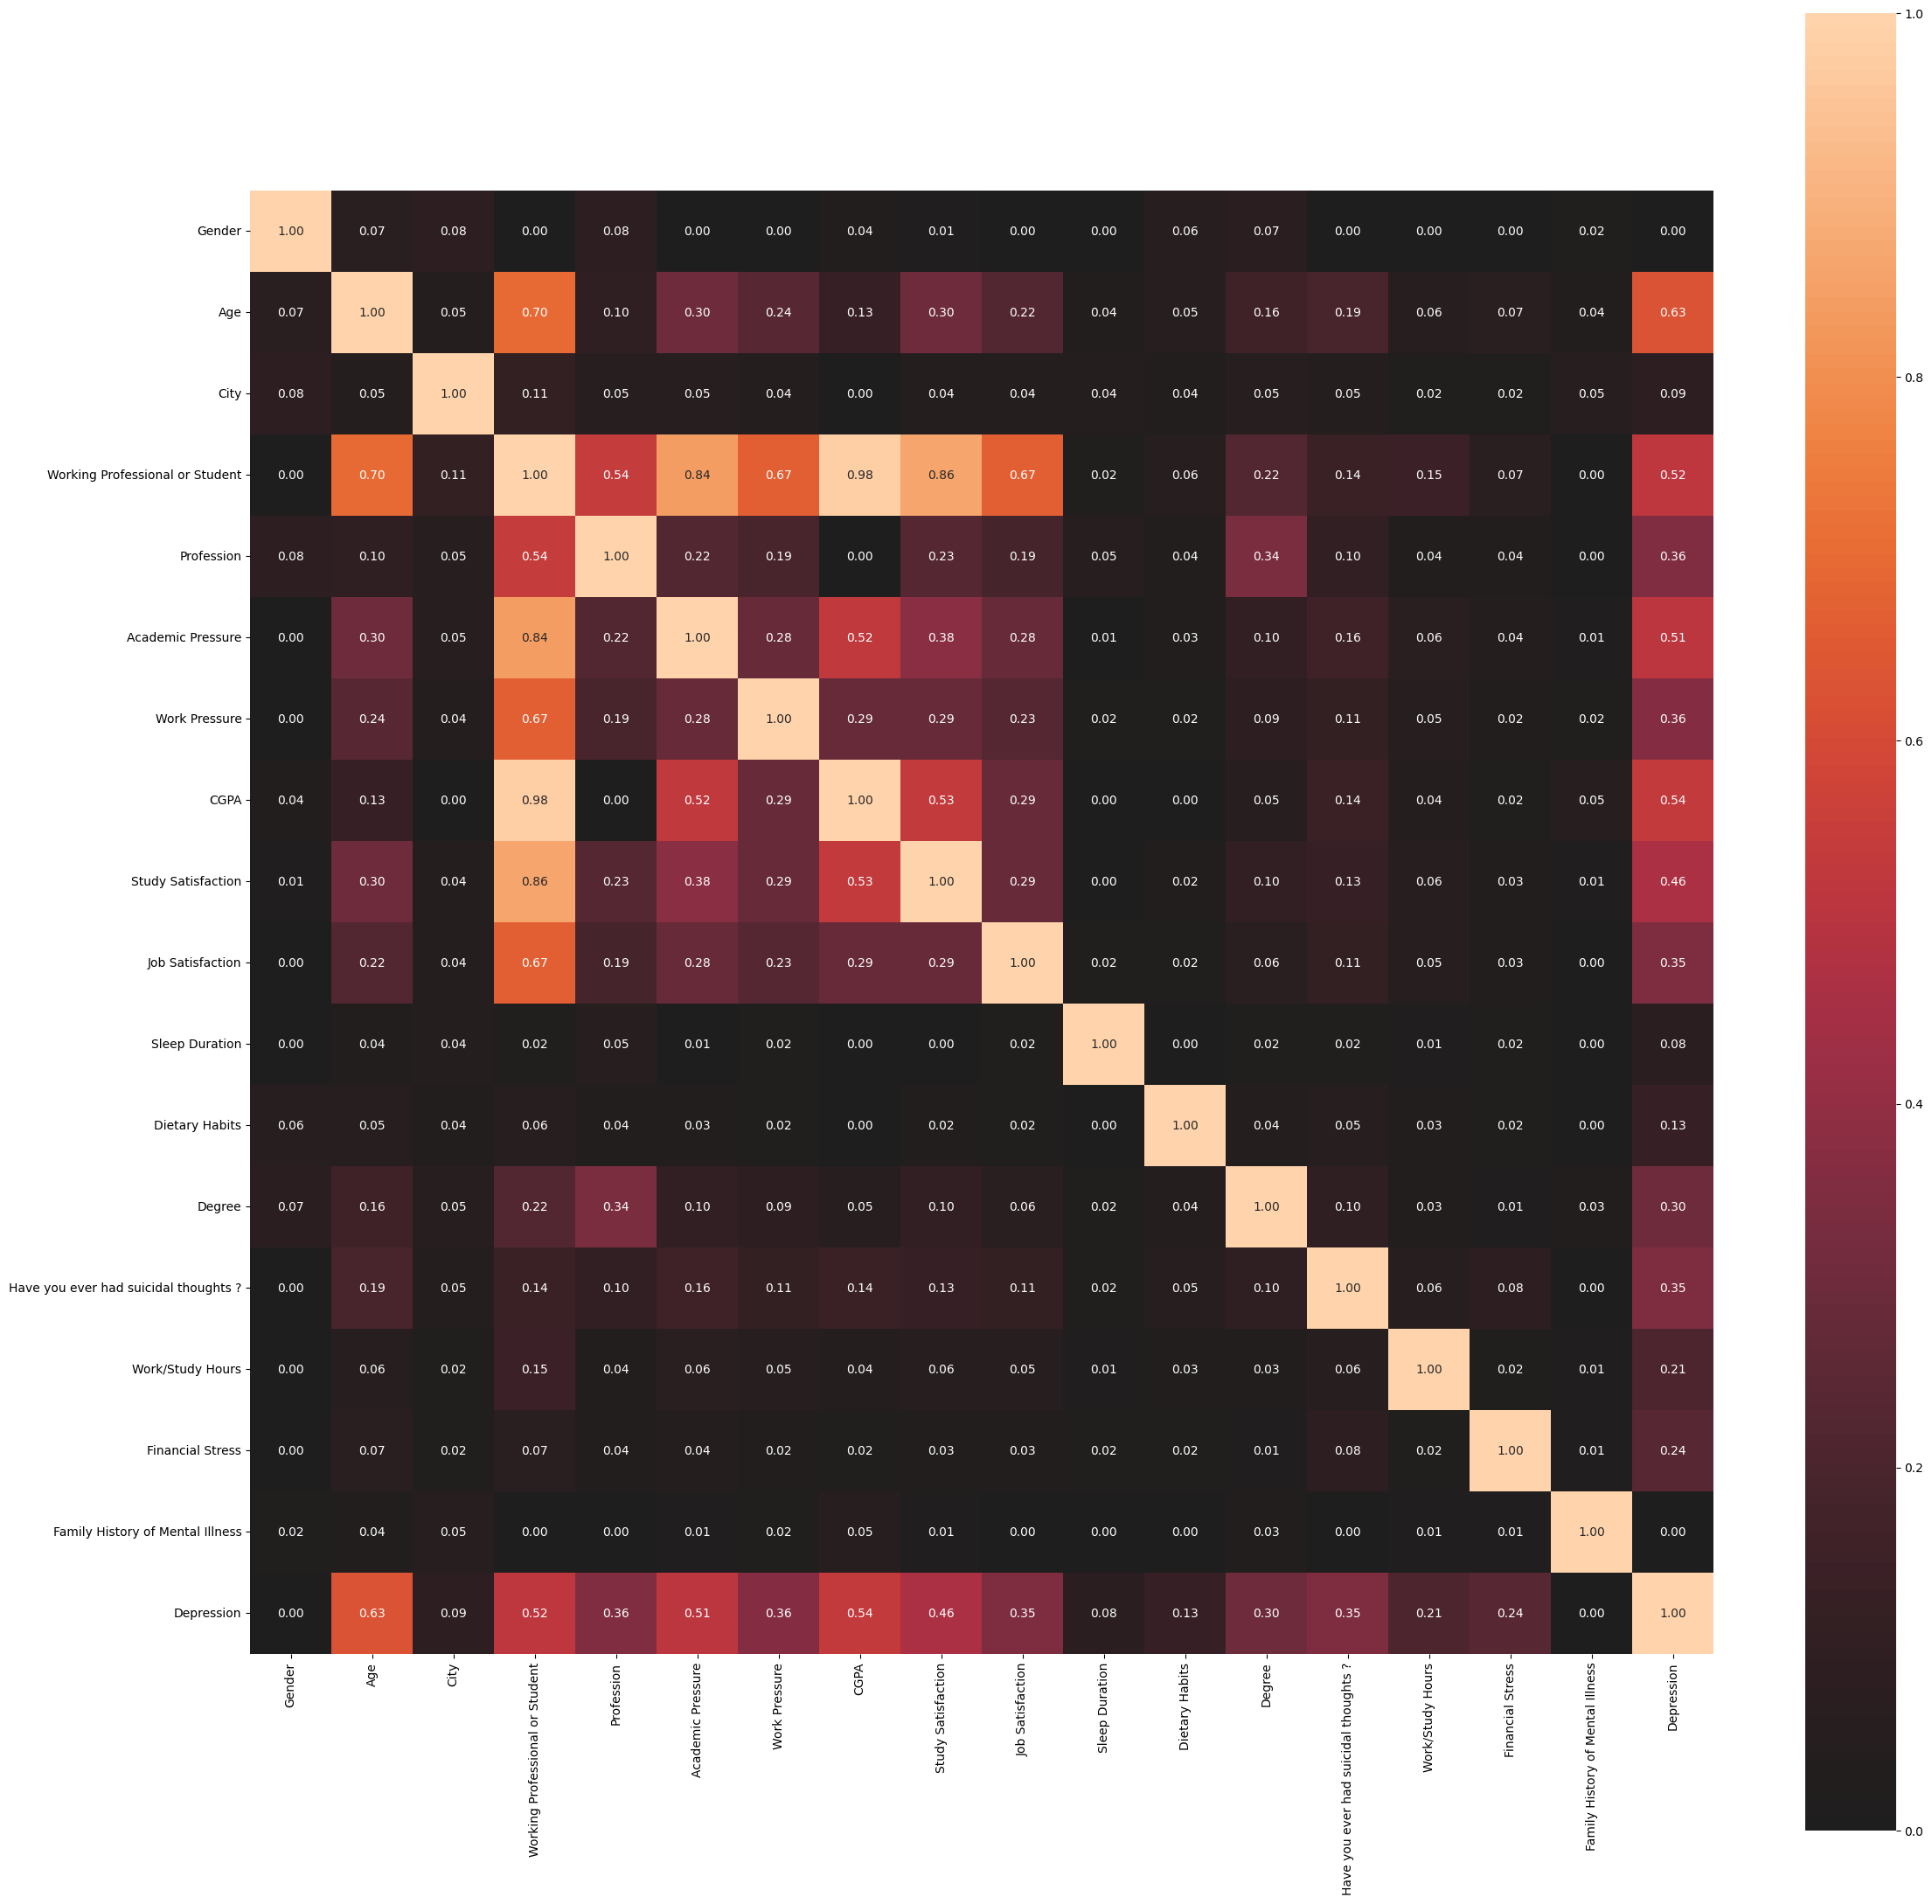

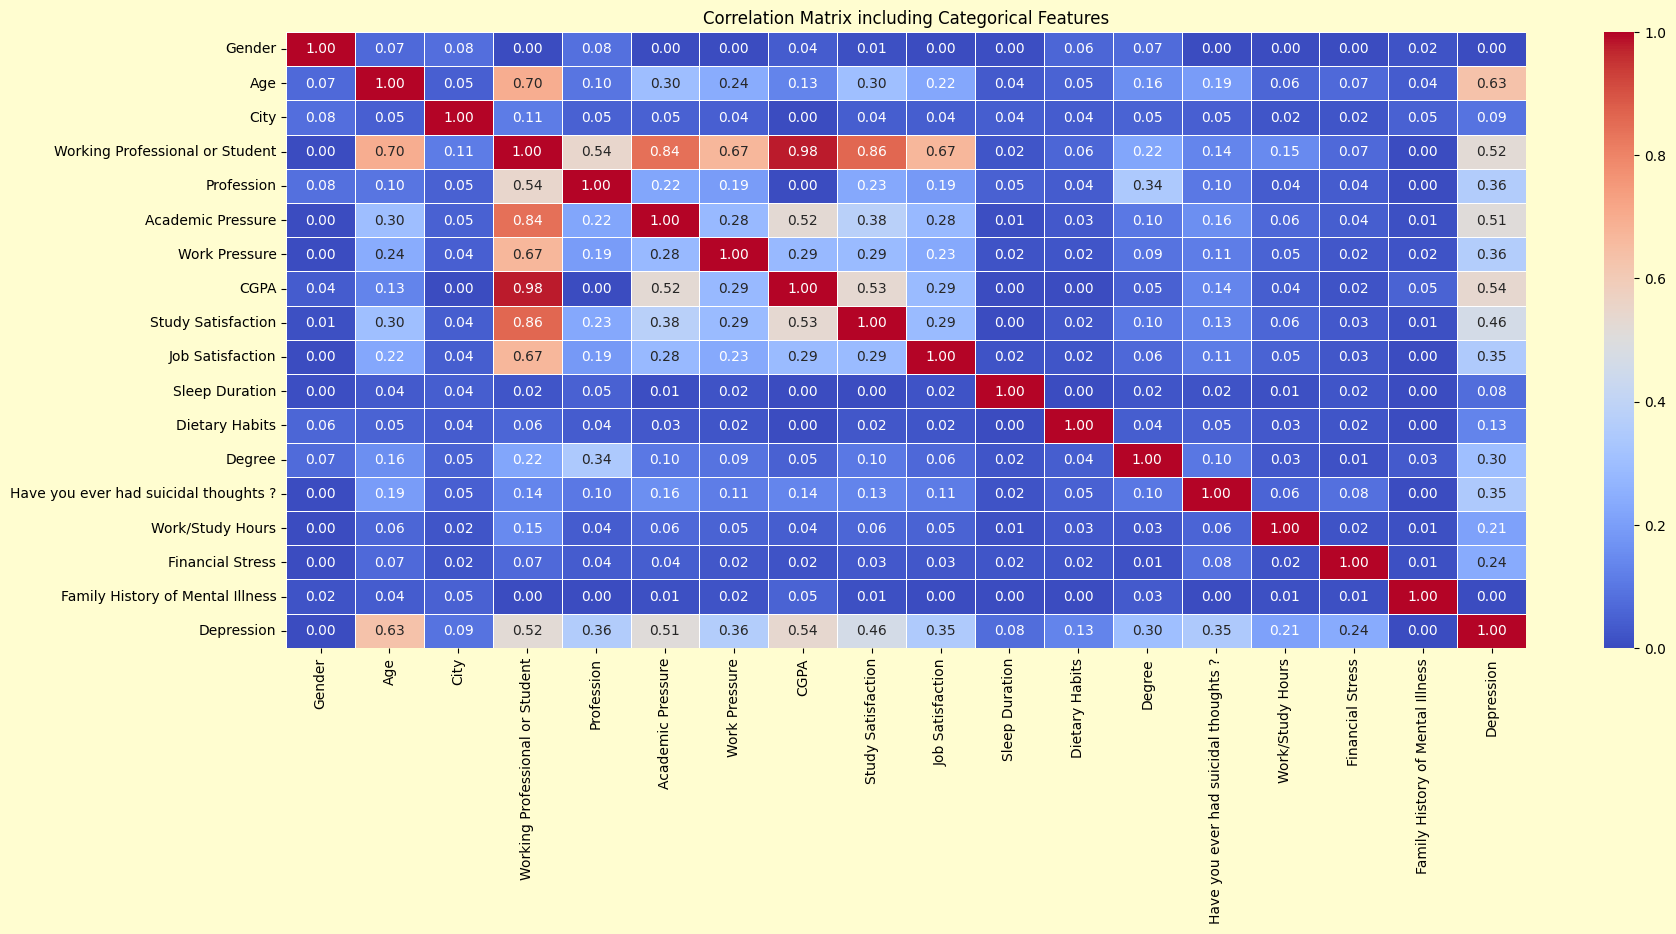

In [ ]:
from dython.nominal import associations

associations_df = associations(df_train[:10000], nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0')
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

In [ ]:
import plotly.express as px
df_train1 = df_train[:10000].copy()

feature_counts = df_train1.groupby(['Gender', 'Age']).size().reset_index(name='count')
fig = px.sunburst(feature_counts, path=['Gender', 'Age'], values='count',
                 color='count', color_continuous_scale='Viridis',
                 title='Sunburst Chart of Cap Shape and Cap Color Distribution')

fig.update_layout(title_text='Sunburst Chart of Cap Shape and Cap Color Distribution',
                  title_x=0.5,width=900,height=600)
fig.show()

In [ ]:
missing_train = df_train.isnull().mean() * 100  # 각 열의 결측치 비율(%) 계산
missing_test = df_test.isnull().mean() * 100   # 각 열의 결측치 비율(%) 계산

In [ ]:
cols_to_drop_train = missing_train[missing_train > 95].index
cols_to_drop_test = missing_test[missing_test > 95].index

df_train = df_train.drop(columns=cols_to_drop_train)
df_test = df_test.drop(columns=cols_to_drop_test)
gc.collect()

32525

In [ ]:
from sklearn.impute import KNNImputer #결측값을 KNNImputer를 사용해 대체하는 함수
import pandas as pd

def knn_impute(df, n_neighbors=5): # K-최근접 이웃 알고리즘에서 사용할 개수(5개)
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors) #KNN 사용해서 결측값 채움.
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

In [ ]:
df_train_imputed = knn_impute(df_train, n_neighbors=5)
df_test_imputed = knn_impute(df_test, n_neighbors=5)

In [ ]:
cat_cols_train = df_train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'Depression']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

In [ ]:
df_train_imputed.head()


,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0.0,49.0,50.0,1.0,10.0,3.0,5.0,7.77,3.0,2.0,29.0,7.0,33.0,0.0,1.0,2.0,0.0,0.0
1,1.0,26.0,93.0,1.0,55.0,3.0,4.0,7.77,3.0,3.0,27.0,20.0,63.0,1.0,7.0,3.0,0.0,1.0
2,1.0,33.0,97.0,0.0,55.0,5.0,3.0,8.97,2.0,3.0,15.0,7.0,21.0,1.0,3.0,1.0,0.0,1.0
3,1.0,22.0,64.0,1.0,55.0,3.0,5.0,7.77,3.0,1.0,27.0,15.0,28.0,1.0,10.0,1.0,1.0,1.0
4,0.0,30.0,37.0,1.0,9.0,3.0,1.0,7.77,3.0,1.0,15.0,20.0,28.0,1.0,9.0,4.0,1.0,0.0


In [ ]:
y = df_train['Depression']
X = df_train.drop(['Depression'],axis=1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def objective(trial):
    # CatBoost 하이퍼파라미터 탐색 공간
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'task_type': 'CPU',  # Changed to 'CPU' to avoid CUDA error
        'random_seed': 42,
        'verbose': False
    }

    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)

    # Get categorical features indices from X_train
    cat_features_indices = [X_train.columns.get_loc(col) for col in cat_cols_train if col in X_train.columns]

    # Pass cat_features to fit method
    model.fit(X_train, y_train,
              cat_features=cat_features_indices,  # Explicitly specify categorical features
              eval_set=(X_valid, y_valid),
              early_stopping_rounds=50)

    # 검증 데이터에 대한 AUC 점수 계산
    y_pred = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)

    # Optuna는 최대화를 기본으로 하므로 -AUC 반환
    return auc

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')  # AUC 최대화
study.optimize(objective, n_trials=50)  # 50번의 시도

# 최적의 하이퍼파라미터 출력
print("Best trial:")
print(study.best_trial.params)

[I 2024-11-28 15:55:02,802] A new study created in memory with name: no-name-82c6c107-c9ea-464d-b9a1-3760df45500a
[I 2024-11-28 15:56:07,879] Trial 0 finished with value: 0.9759329107901481 and parameters: {'learning_rate': 0.23247464644589336, 'iterations': 1199, 'depth': 4, 'l2_leaf_reg': 5.263582521799554, 'random_strength': 2.1328800218650223}. Best is trial 0 with value: 0.9759329107901481.
[I 2024-11-28 15:58:23,601] Trial 1 finished with value: 0.9758602718515731 and parameters: {'learning_rate': 0.055419879777153847, 'iterations': 873, 'depth': 9, 'l2_leaf_reg': 1.1749874311799757, 'random_strength': 9.61121716190078}. Best is trial 0 with value: 0.9759329107901481.
[I 2024-11-28 15:59:06,771] Trial 2 finished with value: 0.9752973302397518 and parameters: {'learning_rate': 0.1508521309196736, 'iterations': 1089, 'depth': 9, 'l2_leaf_reg': 0.03544821049843748, 'random_strength': 5.570017076933734}. Best is trial 0 with value: 0.9759329107901481.
[I 2024-11-28 16:01:17,096] Tria

Best trial:
{'learning_rate': 0.06879648102074604, 'iterations': 984, 'depth': 5, 'l2_leaf_reg': 3.3822389272462816, 'random_strength': 3.906227794153761}


In [ ]:
catboost_params = {
    'learning_rate': 0.06607496999613187,
    'iterations': 1528,
    'depth': 4,
    'l2_leaf_reg': 2.799666559217552,
    'random_strength': 4.439212149043874,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'task_type': 'CPU',  # Changed to 'CPU' to avoid potential CUDA issues
    'verbose': 100  # 학습 로그를 출력
}
# Convert categorical features to strings and fill NaN values with 'missing'
X = X.astype({col: 'str' for col in X.select_dtypes(include=['float', 'int']).columns})
X = X.fillna("missing")
df_test = df_test.astype({col: 'str' for col in df_test.select_dtypes(include=['float', 'int']).columns})
df_test = df_test.fillna("missing")

cv = StratifiedKFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X, y)
scores = []
test_preds = []
X_test_pool = Pool(df_test, cat_features=X.columns.values)
for i, (train_idx, val_idx) in enumerate(cv_splits):
    model = CatBoostClassifier(**catboost_params)
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X.columns.values)
    X_valid_pool = Pool(X_val_fold, y_val_fold, cat_features=X.columns.values)
    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=200)
    val_pred = model.predict(X_valid_pool)
    score = accuracy_score(y_val_fold, val_pred)
    scores.append(score)
    test_pred = model.predict_proba(X_test_pool)[:, 1]
    test_preds.append(test_pred)
    print(f'Fold {i + 1} accuracy_score: {score}')
print(f'Cross-validated accuracy_score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
print(f'Max accuracy_score score: {np.max(scores):.3f}')
print(f'Min accuracy_score score: {np.min(scores):.3f}')



In [ ]:
sample_submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")
sample_submission['Depression'] = np.round(np.mean(test_preds, axis=0))
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)